# SleepImpact – DSA210 Term Project

This notebook analyzes the effect of daily habits such as caffeine intake, social media usage, smoking, and physical activity on sleep quality and onset time.


In [20]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, linregress, ttest_ind
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
import os

plt.rcParams["figure.dpi"] = 110  # Sharper plots


## 1. Data Loading and Cleaning

Load the Excel dataset, standardize columns, parse dates, and fill missing values.


In [10]:
FILE = "dsa 210 term project (2).xlsx"
df = pd.read_excel(FILE)

df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"])

num_cols = [
    "Caffeine (mg)", "Social Media Usage (minutes)", "Cigarettes",
    "Step Count", "Sleep Onset Time (minutes)", "Sleep Quality"
]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
df[num_cols] = df[num_cols].fillna(df[num_cols].mean(numeric_only=True))

print(f">> Shape: {df.shape},  Missing numeric cells filled.")


>> Shape: (25, 7),  Missing numeric cells filled.


## 2. Descriptive Statistics & Correlation

Display summary statistics and a correlation heatmap for all numeric features.


                              count         mean          std    min     25%  \
Caffeine (mg)                  25.0    94.347826    55.739430    0.0    70.0   
Social Media Usage (minutes)   25.0   226.478261   123.862447   64.0   157.0   
Cigarettes                     25.0    24.434783     7.787951   12.0    20.0   
Step Count                     25.0  4550.782609  1993.974903  960.0  2751.0   
Sleep Onset Time (minutes)     25.0    21.000000    12.013881    7.0    14.0   
Sleep Quality                  25.0     6.043478     1.567329    2.0     5.0   

                                 50%     75%     max  
Caffeine (mg)                   70.0   140.0   210.0  
Social Media Usage (minutes)   202.0   275.0   548.0  
Cigarettes                      24.0    28.0    41.0  
Step Count                    4512.0  5312.0  8978.0  
Sleep Onset Time (minutes)      16.0    21.0    57.0  
Sleep Quality                    6.0     7.0     9.0  


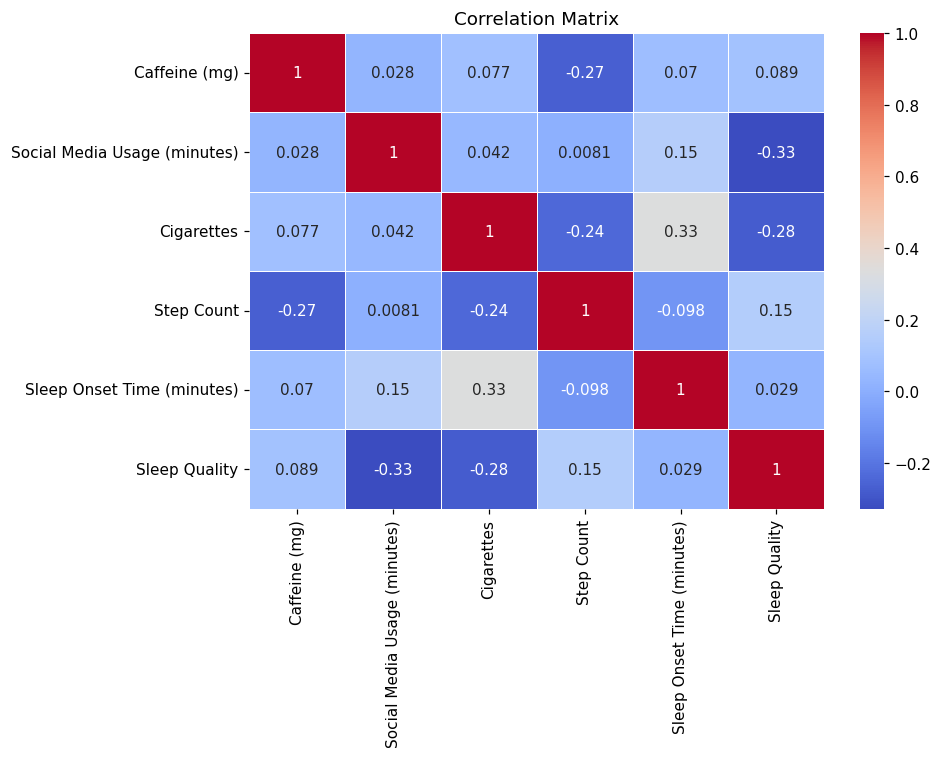

In [11]:
print(df[num_cols].describe().T)

plt.figure(figsize=(9, 7))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


## 3. Visual Explorations

Scatterplots and time series to visually explore relationships in the data.


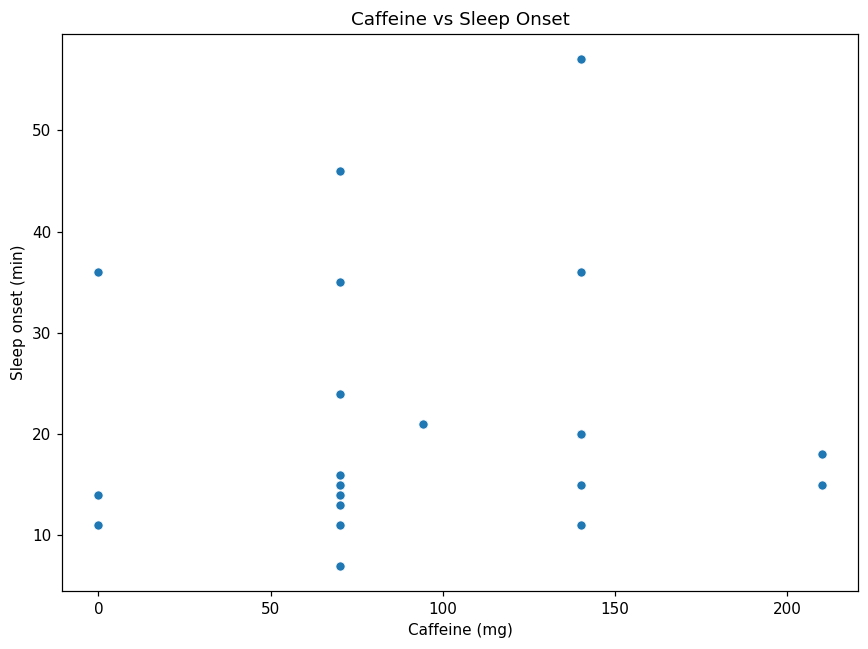

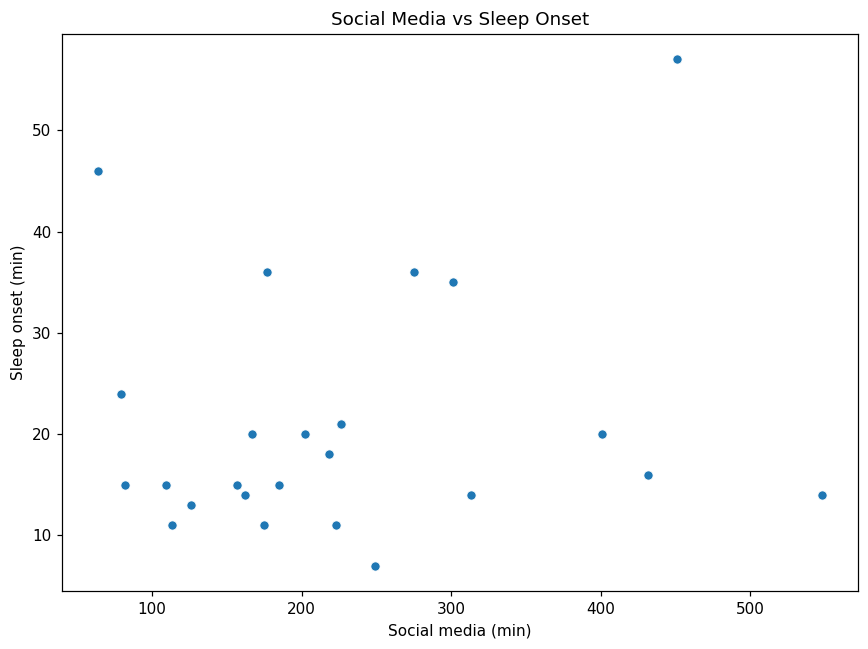

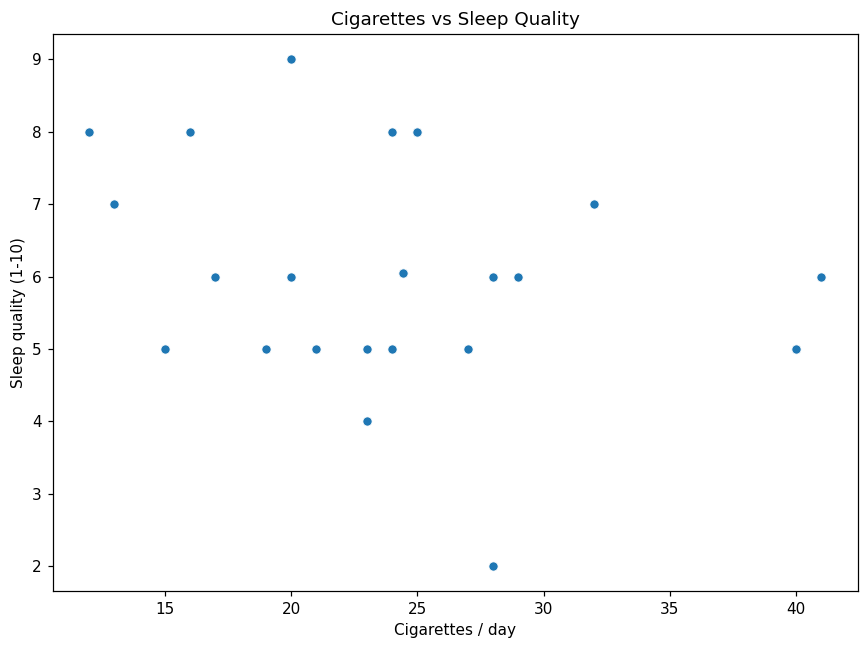

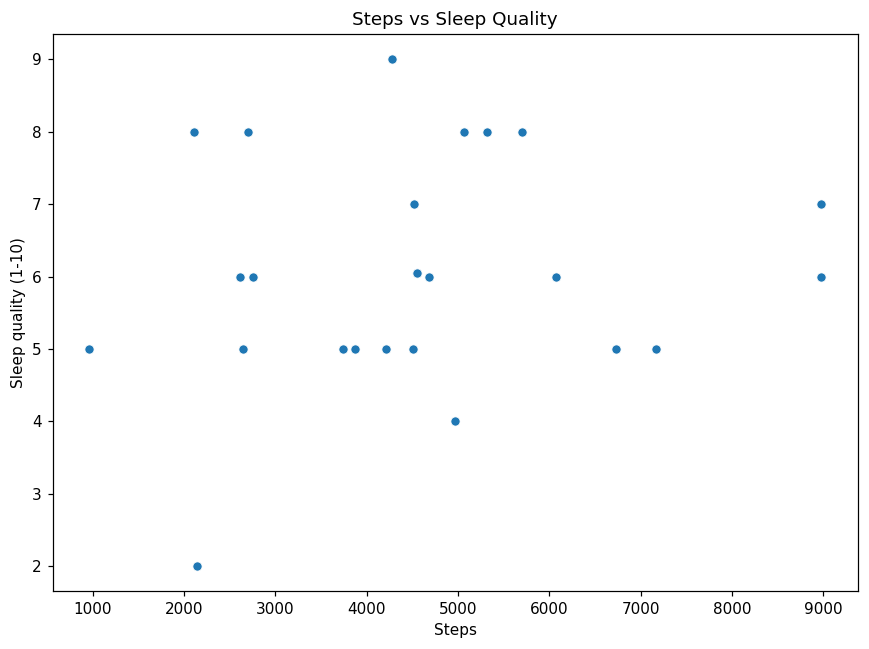

In [12]:
def scatter(x, y, xlabel=None, ylabel=None, title=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y, data=df)
    plt.xlabel(xlabel or x)
    plt.ylabel(ylabel or y)
    plt.title(title or f"{x} vs {y}")
    plt.tight_layout()
    plt.show()

scatter("Caffeine (mg)", "Sleep Onset Time (minutes)",
        "Caffeine (mg)", "Sleep onset (min)", "Caffeine vs Sleep Onset")

scatter("Social Media Usage (minutes)", "Sleep Onset Time (minutes)",
        "Social media (min)", "Sleep onset (min)", "Social Media vs Sleep Onset")

scatter("Cigarettes", "Sleep Quality",
        "Cigarettes / day", "Sleep quality (1-10)", "Cigarettes vs Sleep Quality")

scatter("Step Count", "Sleep Quality",
        "Steps", "Sleep quality (1-10)", "Steps vs Sleep Quality")


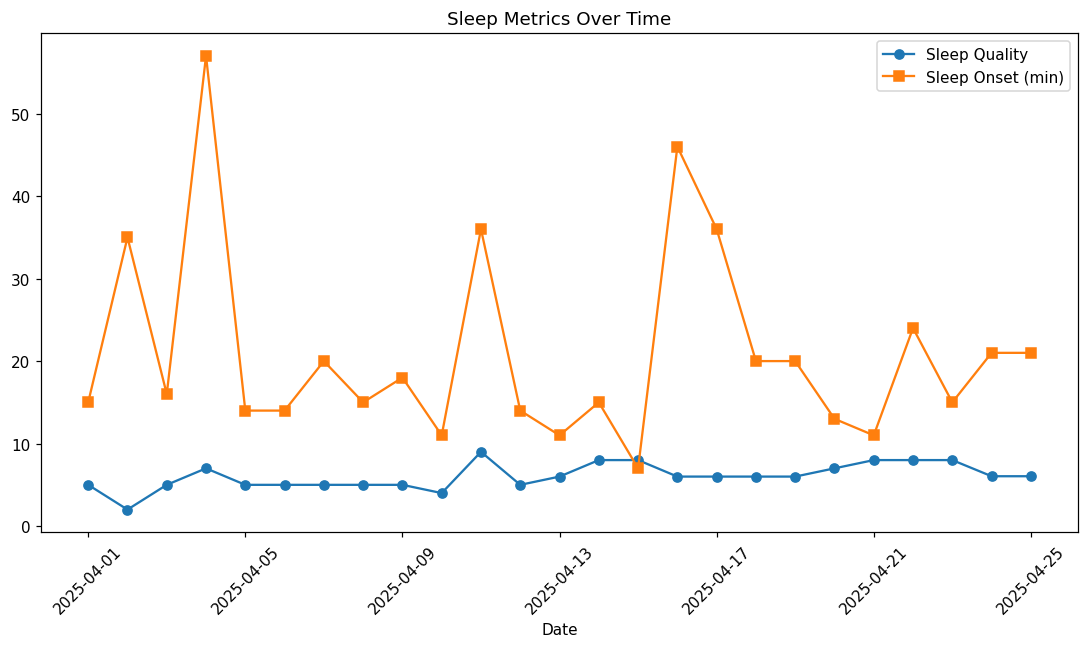

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Sleep Quality"], marker="o", label="Sleep Quality")
plt.plot(df["Date"], df["Sleep Onset Time (minutes)"], marker="s", label="Sleep Onset (min)")
plt.title("Sleep Metrics Over Time")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Hypothesis Testing

Statistical tests (Pearson/Spearman correlations, t-test) to investigate associations between habits and sleep outcomes.


In [14]:
targets = ["Sleep Onset Time (minutes)", "Sleep Quality"]
predictors = ["Caffeine (mg)", "Social Media Usage (minutes)", "Cigarettes", "Step Count"]

for tgt in targets:
    for pred in predictors:
        pr, pp = pearsonr(df[pred], df[tgt])
        sr, sp = spearmanr(df[pred], df[tgt])
        print(f"{pred:30} → {tgt:27} | Pearson r={pr:6.3f} p={pp:.3f} "
              f"| Spearman ρ={sr:6.3f} p={sp:.3f}")

median_caf = df["Caffeine (mg)"].median()
hi_onset = df[df["Caffeine (mg)"] >= median_caf]["Sleep Onset Time (minutes)"]
lo_onset = df[df["Caffeine (mg)"] < median_caf]["Sleep Onset Time (minutes)"]
t_stat, p_val = ttest_ind(hi_onset, lo_onset, equal_var=False)
print(f"\nT-test: High vs Low Caffeine — Sleep Onset: t={t_stat:.2f}, p={p_val:.3f}")


Caffeine (mg)                  → Sleep Onset Time (minutes)  | Pearson r= 0.070 p=0.741 | Spearman ρ= 0.239 p=0.250
Social Media Usage (minutes)   → Sleep Onset Time (minutes)  | Pearson r= 0.155 p=0.461 | Spearman ρ= 0.102 p=0.626
Cigarettes                     → Sleep Onset Time (minutes)  | Pearson r= 0.332 p=0.105 | Spearman ρ= 0.129 p=0.540
Step Count                     → Sleep Onset Time (minutes)  | Pearson r=-0.098 p=0.643 | Spearman ρ=-0.067 p=0.751
Caffeine (mg)                  → Sleep Quality               | Pearson r= 0.089 p=0.674 | Spearman ρ= 0.096 p=0.648
Social Media Usage (minutes)   → Sleep Quality               | Pearson r=-0.328 p=0.109 | Spearman ρ=-0.325 p=0.113
Cigarettes                     → Sleep Quality               | Pearson r=-0.281 p=0.173 | Spearman ρ=-0.206 p=0.324
Step Count                     → Sleep Quality               | Pearson r= 0.149 p=0.477 | Spearman ρ= 0.169 p=0.420

T-test: High vs Low Caffeine — Sleep Onset: t=0.09, p=0.934


## 5. Multiple Regression

Linear regression model to predict sleep onset time from daily habits.


In [15]:
X = df[["Caffeine (mg)", "Social Media Usage (minutes)", "Cigarettes", "Step Count"]]
X = sm.add_constant(X)
y = df["Sleep Onset Time (minutes)"]

model = sm.OLS(y, X).fit()
print(model.summary())


                                OLS Regression Results                                
Dep. Variable:     Sleep Onset Time (minutes)   R-squared:                       0.132
Model:                                    OLS   Adj. R-squared:                 -0.042
Method:                         Least Squares   F-statistic:                    0.7579
Date:                        Thu, 29 May 2025   Prob (F-statistic):              0.565
Time:                                23:08:34   Log-Likelihood:                -95.350
No. Observations:                          25   AIC:                             200.7
Df Residuals:                              20   BIC:                             206.8
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

## 6. Feature Engineering & Machine Learning

Create a new binary feature for high social media usage, and apply logistic regression to predict whether sleep quality is high or low.


In [21]:

# Feature engineering: Create binary feature for high social media usage
median_smu = df["Social Media Usage (minutes)"].median()
df["High_SocialMedia"] = (df["Social Media Usage (minutes)"] > median_smu).astype(int)

# Categorize sleep quality as high/low (based on median)
median_quality = df["Sleep Quality"].median()
df["SleepQuality_Class"] = (df["Sleep Quality"] > median_quality).astype(int)  # 1=High, 0=Low

# Prepare X and y for ML
X_ml = df[["Caffeine (mg)", "Cigarettes", "Step Count", "High_SocialMedia"]]
y_ml = df["SleepQuality_Class"]

# Scale features for better convergence
scaler = StandardScaler()
X_ml_scaled = scaler.fit_transform(X_ml)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ml_scaled, y_ml, test_size=0.25, random_state=42)

# Logistic Regression model with increased max_iter
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

# Results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"\nLogistic Regression Accuracy: {acc:.2f}")
print("Confusion Matrix:\n", cm)



Logistic Regression Accuracy: 0.43
Confusion Matrix:
 [[3 2]
 [2 0]]


\## 7. Export Correlation Matrix


In [17]:
corr_path = "sleep_corr_matrix.csv"
df[num_cols].corr().to_csv(corr_path)
print(f"Correlation matrix saved to '{corr_path}'.")
print("Working directory:", os.getcwd())


Correlation matrix saved to 'sleep_corr_matrix.csv'.
Working directory: /content


## 8. Conclusion

This analysis revealed which daily habits most affect sleep onset and quality. Further data collection and model improvements could provide even deeper insights in the future.
